In [13]:
from obspy import read, UTCDateTime
import numpy as np
import glob
import matplotlib.pyplot as plt
from python_speech_features import mfcc, logfbank, delta, fbank
import speechpy as spe
%matplotlib inline


p_files = glob.glob("/home/daniel/Data/wf_512/P/*.mseed")
n_files = glob.glob("/home/daniel/Data/wf_512/N/*.mseed")
ruta_p = "/home/daniel/Data/wf/P/P_SGC2018hhuz_20180414-211832_HHZ.mseed"
ruta_s = "/home/daniel/Data/wf/S/S_SGC2018gocz_20180404-023835_HHZ.mseed"
ruta_n = "/home/daniel/Data/wf/N/N_SGC2018gohj_20180404-045038_HHZ.mseed"

wf = [p_files[1408], n_files[1408]]

st = read(n_files[4])
st_p = read(p_files[4])
#latest_start = np.max([x.stats.starttime for x in st])
#earliest_stop = np.min([x.stats.endtime for x in st])
#st.trim(latest_start, earliest_stop)
st.detrend(type='linear')
tr =st[0]
delta = tr.stats.delta
df = tr.stats.sampling_rate
x = tr.data
# 512 --> 200 80, 256 --> 100 40
feat_mfcc_ = mfcc(x, df, 100/df, 40/df,numcep=13,nfilt=26)
#                  nfft=1024,highfreq=None,preemph=0.97,ceplifter=22,appendEnergy=True)
#feat_new = feat_mfcc_
feat_new = feat_mfcc_.reshape(1,feat_mfcc_.shape[1]*feat_mfcc_.shape[0])
print(feat_new.shape)
mfcc_cmvn_201 = spe.processing.cmvnw(feat_new,201, variance_normalization=False)
mfcc_cmvn_301 = spe.processing.cmvnw(feat_new,301, variance_normalization=True)

plt.matshow(feat_new)
plt.title("MFCC")
plt.figure(clear=True)
plt.matshow(mfcc_cmvn_201)
plt.title("MFCC CMVN 201")
plt.figure(clear=True)
plt.matshow(mfcc_cmvn_301)
plt.title("MFCC CMVN 301")
#st.filter("bandpass", freqmin=filt[2][0], freqmax=filt[2][1], corners=4)
#st_.spectrogram(log=False, title=st[0].stats.station +" "+ str(st[0].stats.starttime))

nan -2.44948974278 2.64575131106 7.0
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan -2.44948974  2.64575131  2.98069352  3.31563572  3.65057793
  3.98552014  4.32046235  4.65540455  4.99034676  5.32528897  5.66023117
  5.99517338  6.33011559  6.66505779  7.        ]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan   1.]
[  8.           9.88453385  11.99344026  14.32671923  16.88437077
  19.66639488  22.67279154  25.90356077  29.35870257  33.03821693
  36.94210385  41.07036334  45.42299539  50.        ]


/home/daniel/python_speech_features/python_speech_features/base.py:123: RuntimeWarning: invalid value encountered in sqrt
  else: return -numpy.sqrt(hz-1)


ValueError: cannot convert float NaN to integer

La idea es que la matriz $X$ de características contenga una columnta por cada característica. Por lo pronto 16. Tres de las componentes normales, 12 de las componente filtradas (4 filtros) y 3 de los espectogramas a cada componente 

/home/daniel/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/daniel/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log


-0.0 -2.44948974278 2.64575131106 7.0
[-0.         -0.18842229 -0.37684458 -0.56526686 -0.75368915 -0.94211144
 -1.13053373 -1.31895602 -1.5073783  -1.69580059 -1.88422288 -2.07264517
 -2.26106745 -2.44948974  2.64575131  2.98069352  3.31563572  3.65057793
  3.98552014  4.32046235  4.65540455  4.99034676  5.32528897  5.66023117
  5.99517338  6.33011559  6.66505779  7.        ]
[ 7.          6.96449704  6.85798817  6.68047337  6.43195266  6.11242604
  5.72189349  5.26035503  4.72781065  4.12426036  3.44970414  2.70414201
  1.88757396  1.        ]
[  8.           9.88453385  11.99344026  14.32671923  16.88437077
  19.66639488  22.67279154  25.90356077  29.35870257  33.03821693
  36.94210385  41.07036334  45.42299539  50.        ]
-0.0 -2.44948974278 2.64575131106 7.0
[-0.         -0.18842229 -0.37684458 -0.56526686 -0.75368915 -0.94211144
 -1.13053373 -1.31895602 -1.5073783  -1.69580059 -1.88422288 -2.07264517
 -2.26106745 -2.44948974  2.64575131  2.98069352  3.31563572  3.65057793
  3.9

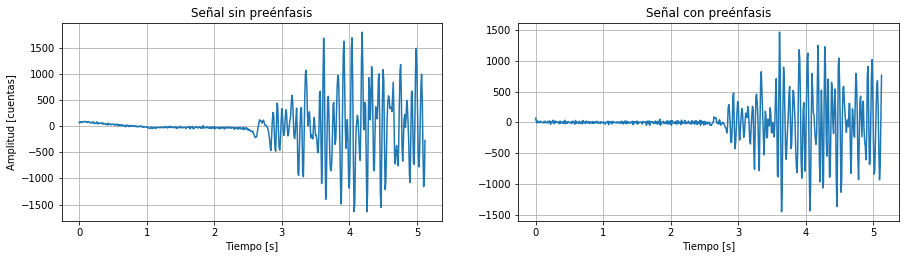

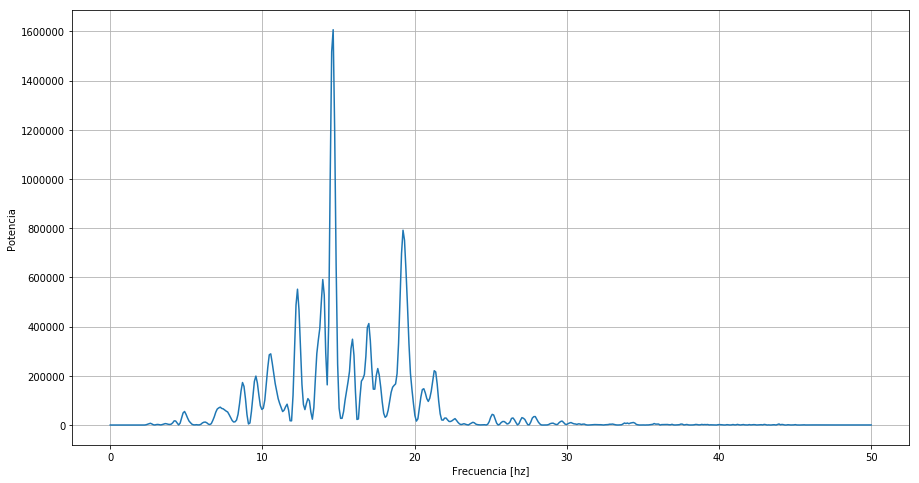

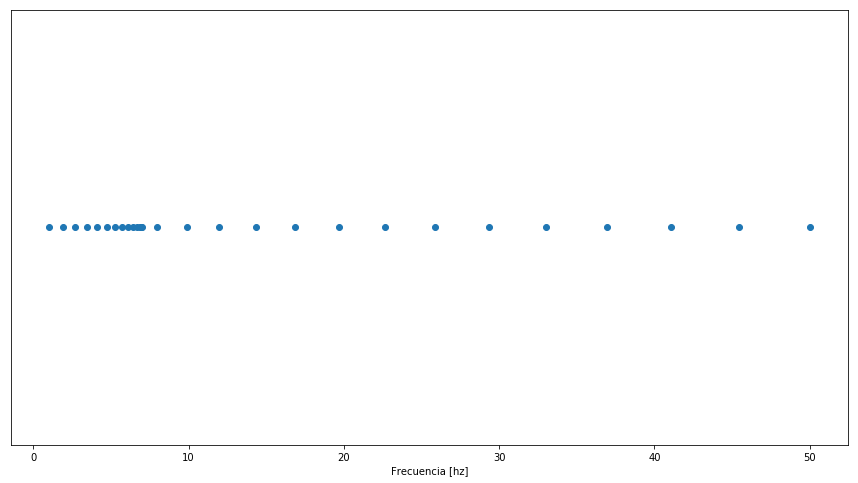

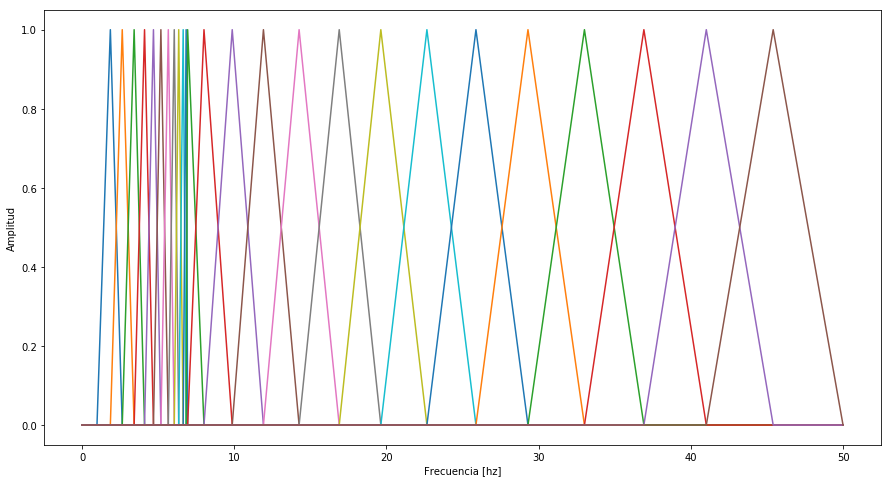

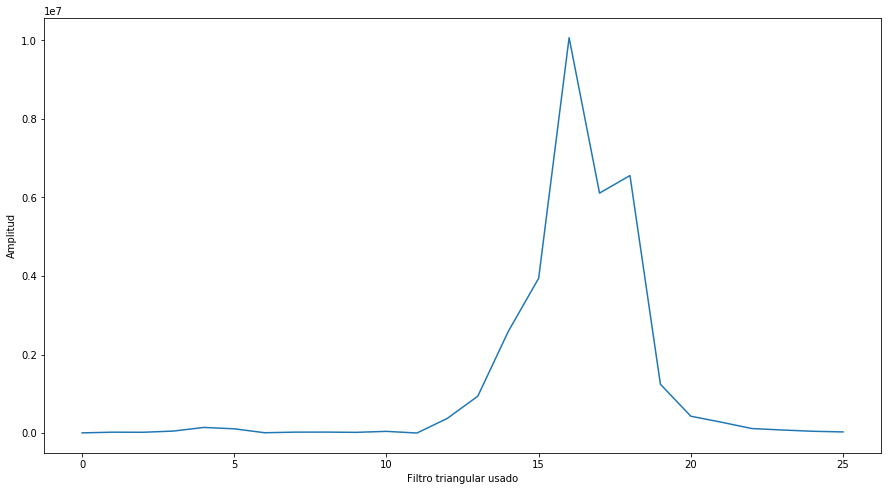

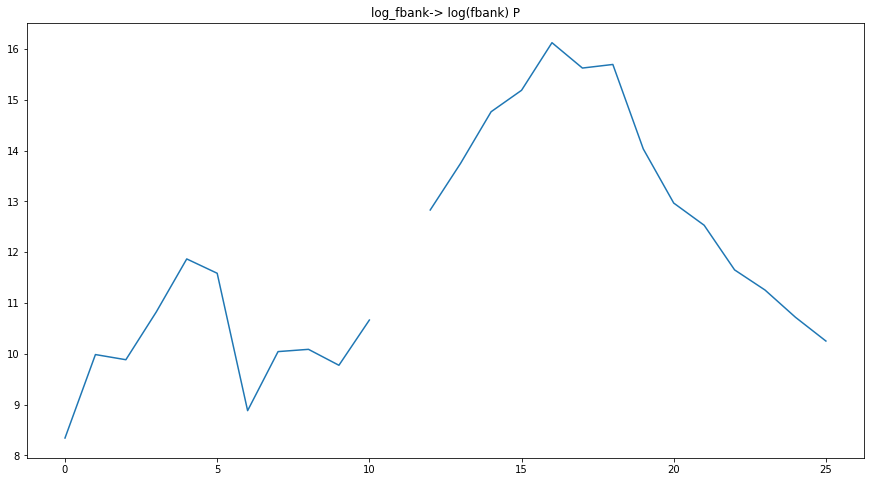

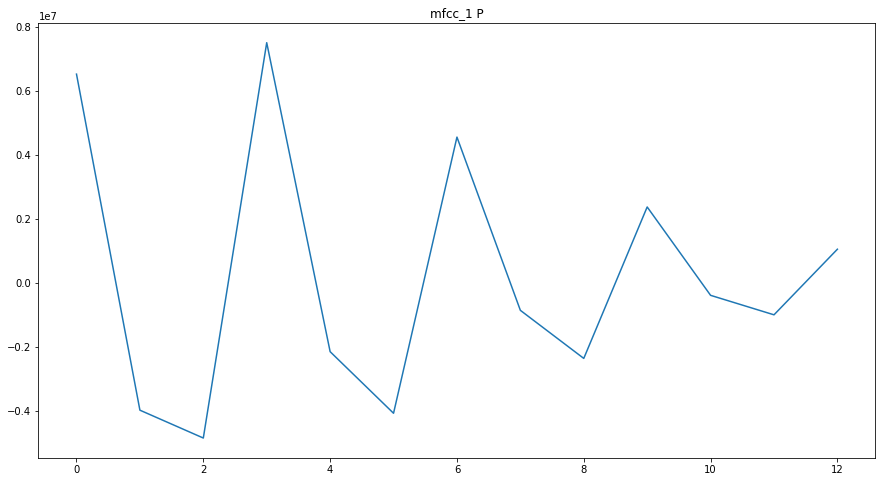

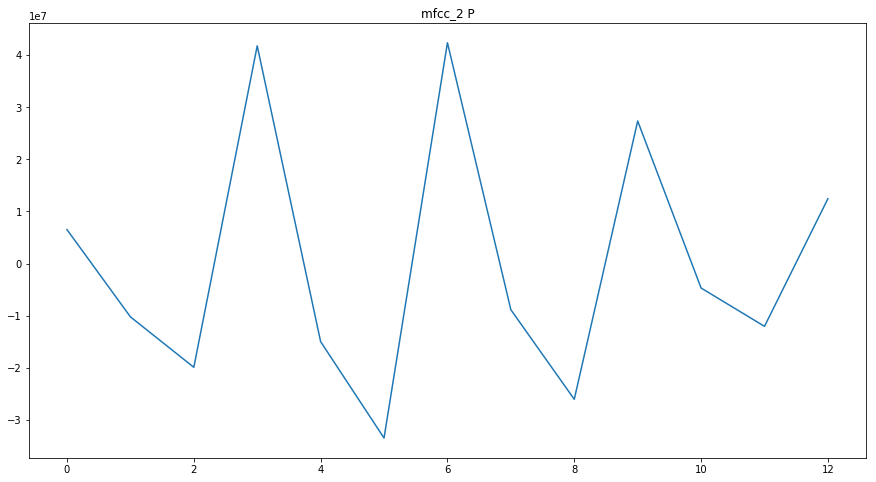

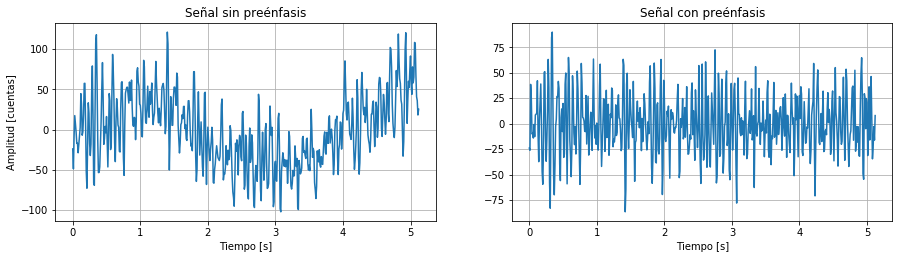

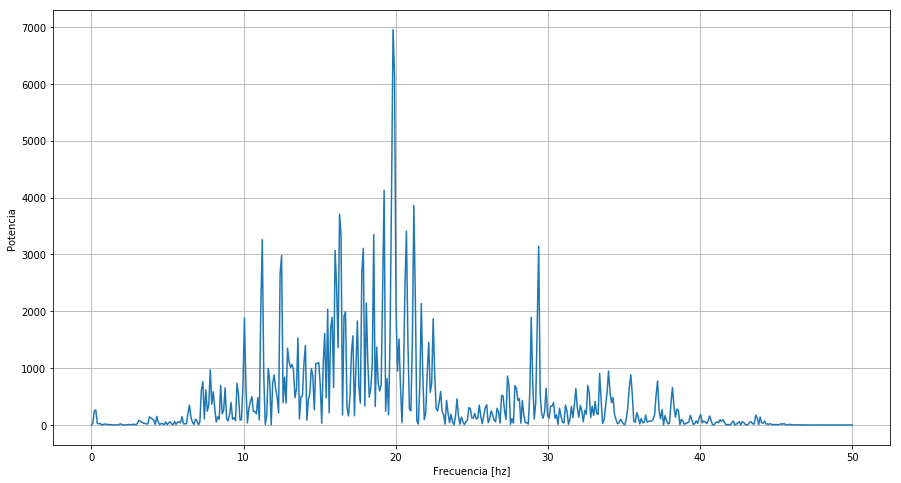

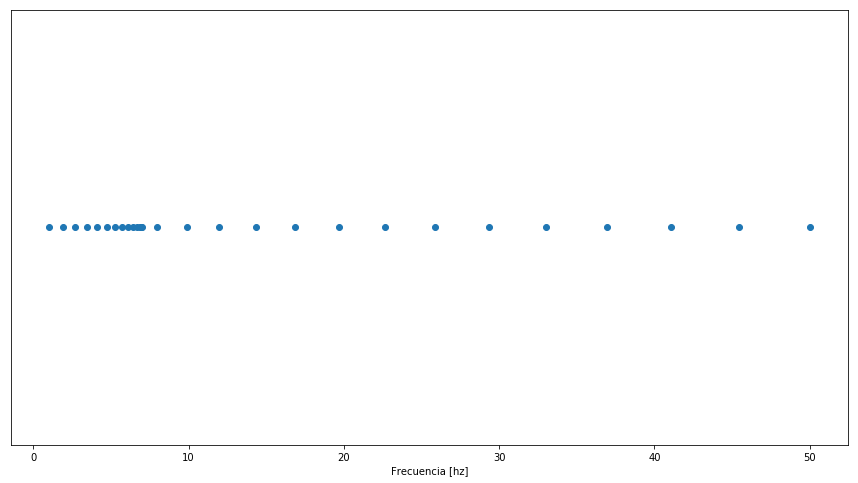

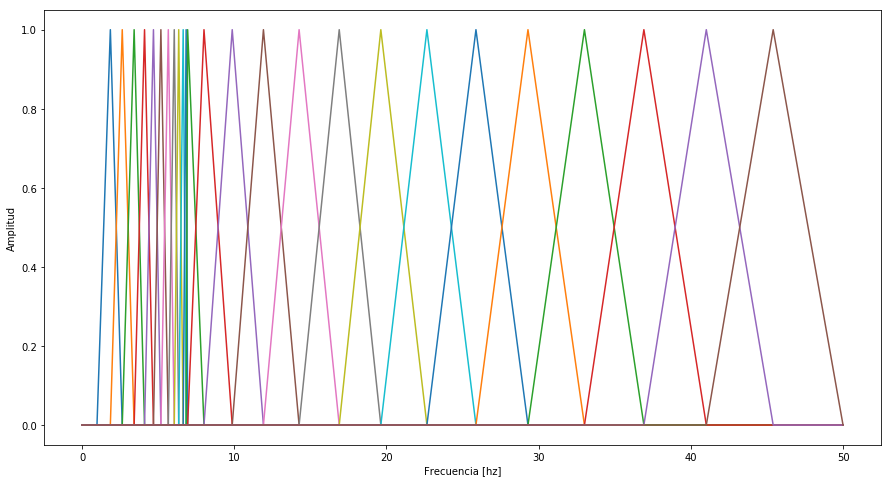

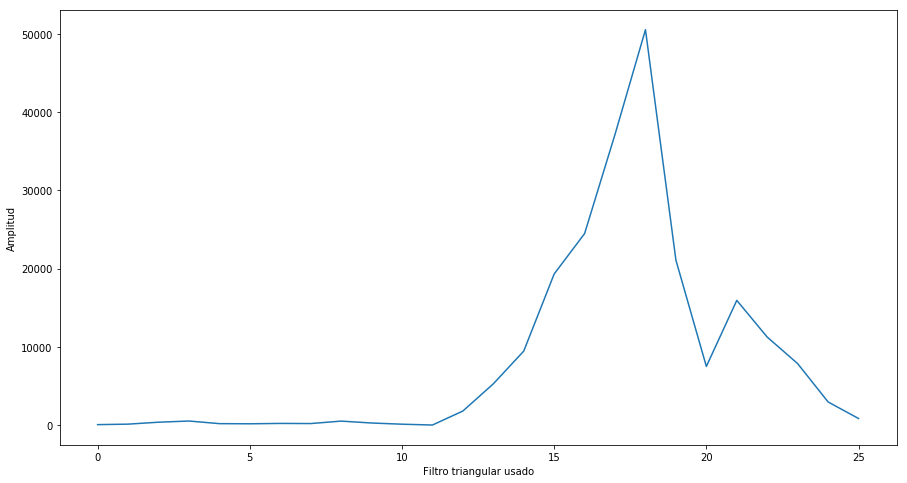

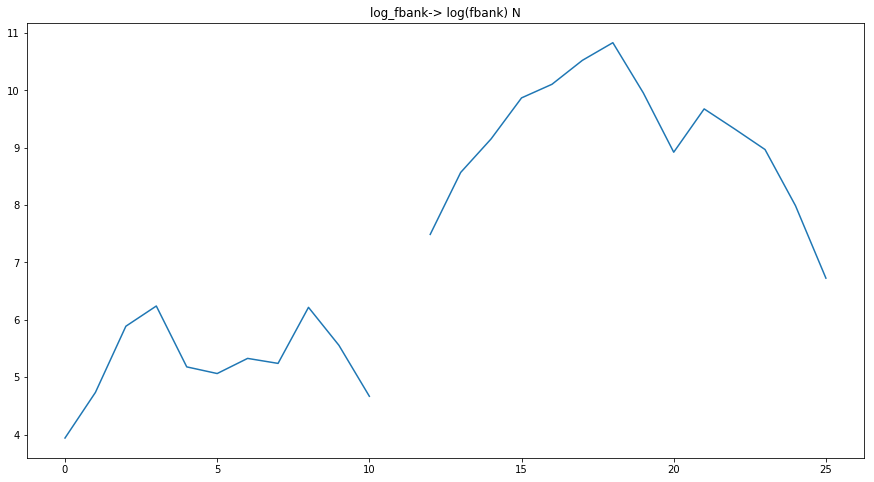

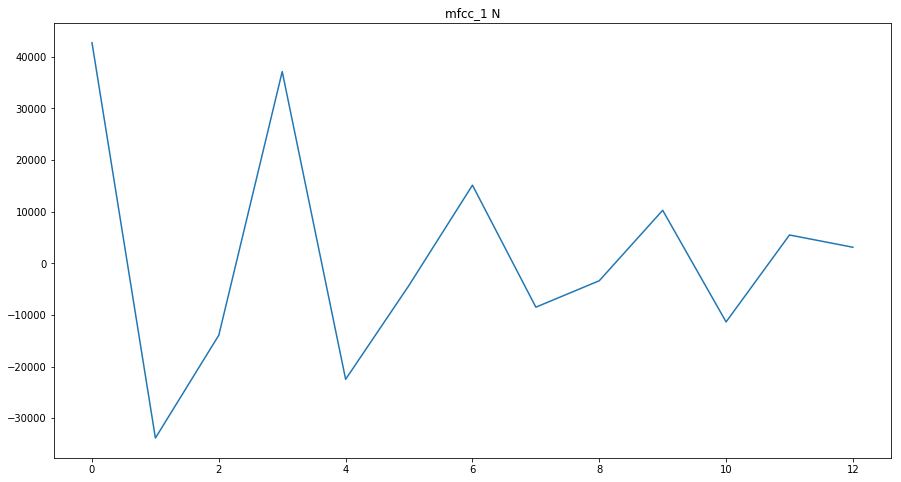

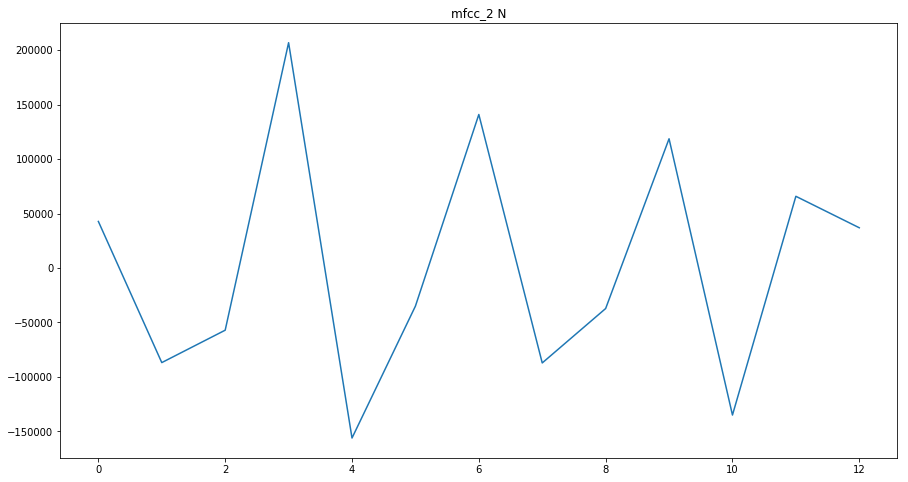

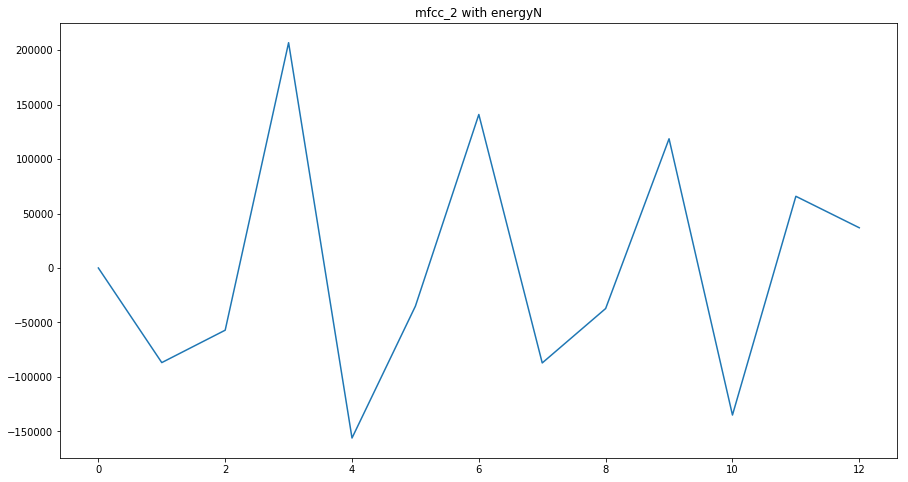

In [27]:
from python_speech_features import sigproc, get_filterbanks, lifter, hz2mel, mel2hz
import numpy
from scipy.fftpack import dct
plt.rcParams['figure.figsize'] = 15, 8
for w in wf:
    # obteniendo si la forma de onda es de P, S o ruido
    ph_type = w.split("/")[-1].split("_")[0]
    st_ = read(w)
    st = st_.copy()
    
    st.detrend(type='linear')
    tr =st[0]
    #tr.plot()
    df = tr.stats.sampling_rate
    x = tr.data
    # obteniendo los coeficientes MFCC
    """winlen representa el largo de la ventana en segundos, con 200/df se selecciona 
       una ventana de 200 datos. winstep es la ventana de deslizamiento, calcula una nueva
       ventana cada 80 datos.
       En numcep se selecciona el número de coeficientes de la transformada discreta de coseno
       que se cogeran. Se pueden un máximo del parámetro nfilt, que por defecto es 26, acá se 
       seleccionó para coger los primeros 13 coeficientes (estandar en ASR).
       
       Como la función mfcc devuelve una matriz de total ventanas calculadas por numcep, se hizo
       un reshape para dejar los datos en un solo vector fila"""
    winlen = 5.13
    winstep = 100
    nfilt = 26
    nfft = 1024
    winfunc=lambda x:numpy.ones((x,))
    highfreq= df/2
    lowfreq = 1
    ceplifter = 22
    numcep = 13
    t = np.arange(len(x))/100
    f = np.linspace(0,highfreq,nfft/2+1)
    # la amplitud de la señal queda 5% de lo que era originalmente
    signal = sigproc.preemphasis(x,0.95)
    plt.subplot(221)
    plt.plot(t,x)
    plt.title("Señal sin preénfasis")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [cuentas]")
    plt.grid()
    plt.subplot(222)
    plt.plot(t,signal)
    plt.title("Señal con preénfasis")
    plt.xlabel("Tiempo [s]")
    plt.grid()
    #print("type signal",type(signal),"shape", signal.shape)
    # se divide en ventanas. Como en este caso el tamaño de la ventana es igual al de la señal (256)
    # queda una sola ventana (igual)
    frames = sigproc.framesig(signal, winlen*df, winstep*df, winfunc)
    #print("type frames",type(frames),"shape", frames.shape)
    pspec = sigproc.powspec(frames,nfft)
    #print("type pspec",type(pspec),"shape", pspec.shape)
    plt.figure()
    plt.plot(f,pspec[0])
    #plt.title("Espectro de potencia de fase P")
    plt.xlabel("Frecuencia [hz]")
    plt.ylabel("Potencia")
    plt.grid()
    # Calculando la energía
    energy = numpy.sum(pspec,1) # this stores the total energy in each frame
    energy = numpy.where(energy == 0,numpy.finfo(float).eps,energy) # if energy is zero, we get problems with log
    fb, hz_points = get_filterbanks(nfilt,nfft,df,lowfreq,highfreq, points=True)
    #print(hz_points)
    plt.figure()
    plt.plot(hz_points,np.zeros(len(hz_points)),"o")
    #plt.title("Extremos del banco de filtros centrado en 7 hertz")
    plt.xlabel("Frecuencia [hz]")
    plt.yticks([], [])
    #print("type fb",type(fb),"shape", fb.shape)
    plt.figure()
    for i in range(len(fb)):
        plt.plot(f,fb[i])
    #plt.legend()
    #plt.title("Banco de filtros triangulares centrados en 7 hertz")
    plt.xlabel("Frecuencia [hz]")
    plt.ylabel("Amplitud")
    
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    #print("type feat",type(feat),"shape", feat.shape)
    plt.figure()
    plt.plot(feat[0])
    plt.ylabel("Amplitud")
    plt.xlabel("Filtro triangular usado")
    #plt.title("fbank-> power_espectrum * fb "+ph_type)
    log_feat = np.log(feat)
    #print("type log_feat",type(log_feat),"shape", log_feat.shape)
    plt.figure()
    plt.plot(log_feat[0])
    plt.title("log_fbank-> log(fbank) "+ph_type)
    mfcc_1 = dct(feat, type=2, axis=1, norm='ortho')[:,:numcep]
    #print("type mfcc_1",type(mfcc_1),"shape", mfcc_1.shape)
    plt.figure()
    plt.plot(mfcc_1[0])
    plt.title("mfcc_1 "+ph_type)
    # aplicando filtro para aumentar la magnitud de los coeficientes de frecuencias altas de la DCT
    mfcc_2 = lifter(mfcc_1,ceplifter)
    #print("type mfcc_2",type(mfcc_2),"shape", mfcc_2.shape)
    plt.figure()
    plt.plot(mfcc_2[0])
    plt.title("mfcc_2 "+ph_type)
    # replace first cepstral coefficient with log of frame energy
    mfcc_2[:,0] = numpy.log(energy)
    plt.figure()
    plt.plot(mfcc_2[0])
    plt.title("mfcc_2 with energy"+ph_type)
    """#f_fbank, energy = fbank(x, df, 512/df, 80/df)
    print(type(f_fbank), f_fbank.shape)
    feat_mfcc_ = mfcc(x, df, 512/df, 80/df)
    feat_new = feat_mfcc_.reshape(1,feat_mfcc_.shape[1]*feat_mfcc_.shape[0])
    print('\nMFCC:\nNumber of windows =', feat_new.shape[0])
    print('Length of each feature =', feat_new.shape[1])
    plt.figure(clear=True)
    plt.matshow(feat_mfcc_)
    plt.title(ph_type)"""


**get_filterbanks** es la función que define los filtros para calcular los filterbanks. Habría que modificarla para asegurarse que considere frecuencias relevantes en los sismos. Para ello también hay que modificar la función **hz2mel** que define la escala de Mel. 

In [ ]:
nfilt = 16
lowfreq = 1
highfreq = 10
lowfreq2 = 10+1
highfreq2 = 50
def my_mel2hz(x,t=1):
    if t==1: return (x)**2+1
    else: return -(x)**2+1
def my_hz2mel(x, t=1):
    if t==1: return np.sqrt(x-1)
    else: return -np.sqrt(x-1)
print(lowfreq, highfreq)
lowmel1 = my_hz2mel(lowfreq,2)
highmel1 = my_hz2mel(highfreq,2)
lowmel2 = my_hz2mel(lowfreq2)
highmel2 = my_hz2mel(highfreq2)
#lowmel = highmel/2
step = nfilt/2+1
#step = nfilt/2+1
print(lowmel1,highmel1,lowmel2,highmel2)
#melpoints = np.zeros(step)
melpoints1 = numpy.linspace(lowmel1,highmel1,int(step))
melpoints2 = numpy.linspace(lowmel2,highmel2,int(step))
#melpoints = numpy.linspace(lowmel2,highmel2,nfilt/2+1)
melpoints = np.append(melpoints1,melpoints2)
hz1 = my_mel2hz(melpoints1,2)+9
hz2 = my_mel2hz(melpoints2)
hz = np.append(hz1,hz2)
#print(melpoints1, melpoints2)  
y = np.zeros([len(melpoints)])
#hz = -my_mel2hz(melpoints,2)
print(melpoints)
print(hz)
print(numpy.sort(hz))
plt.subplot(2,2,1)
plt.plot(hz, y, "o")
plt.subplot(2,2,2)
plt.plot(melpoints, hz, "o")
#plt.plot(melpoints)
#plt.plot(my_hz2mel(np.linspace(1,300,16)))
#plt.plot(my_mel2hz(np.linspace(3,12,16)))

In [ ]:
print(my_mel2hz(16), my_mel2hz(16.875), my_mel2hz(17))

In [ ]:
tr = st[0]

In [ ]:
tr.stats.channel